In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imageio
import sys
import os
PATH = './bee_imgs/bee_imgs/'

In [40]:
honey_bee_df = pd.read_csv('bee_data.csv')

In [41]:
#honey_bee_df.shape
honey_bee_df.head()
#honey_bee_df.isnull().sum()

image_files = list(os.listdir(PATH))
print("Number of image files: {}".format(len(image_files)))

file_names = list(honey_bee_df['file'])
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Number of image files: 5172
Matching image names: 5172


In [42]:
tmp = honey_bee_df.groupby(['zip code'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()

honey_bee_df = honey_bee_df.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')

Text(0, 0.5, 'Location')

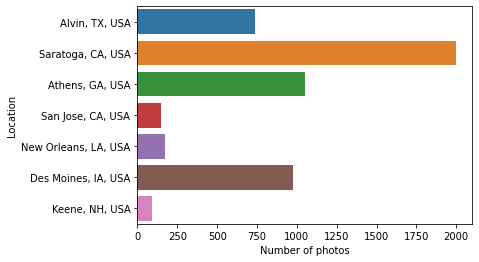

In [43]:
sns.countplot(y= 'location', data= honey_bee_df )
plt.xlabel('Number of photos')
plt.ylabel('Location')

In [44]:
locations = (honey_bee_df.groupby(['location'])['location'].nunique()).index

In [45]:
def draw_category_images(var,cols=5):
    categories = (honey_bee_df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(2*cols,2*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = honey_bee_df[honey_bee_df[var]==cat].sample(cols)
        for j in range(0,cols):
            file=PATH + sample.iloc[j]['file']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()

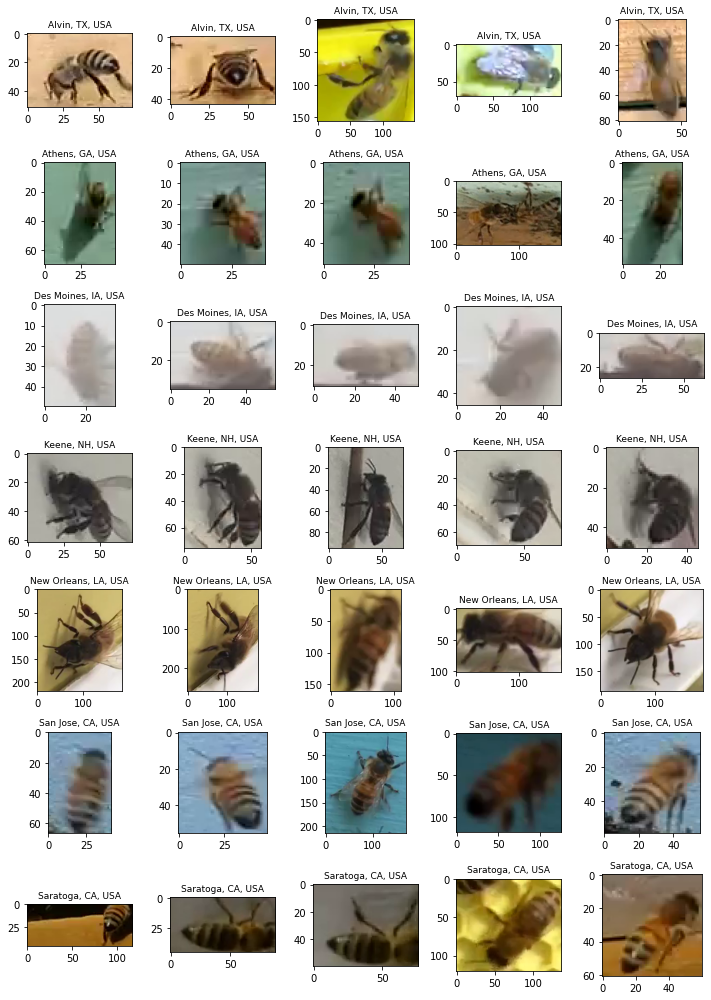

In [46]:
draw_category_images("location")

In [47]:
honey_bee_df['date_time'] = pd.to_datetime(honey_bee_df['date'] + ' ' + honey_bee_df['time'])
honey_bee_df["year"] = honey_bee_df['date_time'].dt.year
honey_bee_df["month"] = honey_bee_df['date_time'].dt.month
honey_bee_df["day"] = honey_bee_df['date_time'].dt.day
honey_bee_df["hour"] = honey_bee_df['date_time'].dt.hour
honey_bee_df["minute"] = honey_bee_df['date_time'].dt.minute

In [48]:
tmp = honey_bee_df.groupby(['subspecies'])['year'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

,subspecies,year,Images
0,-1,2018,428
1,1 Mixed local stock 2,2018,472
2,Carniolan honey bee,2018,501
3,Italian honey bee,2018,3008
4,Russian honey bee,2018,527
5,VSH Italian honey bee,2018,199
6,Western honey bee,2018,37


Text(0, 0.5, 'Subspecies')

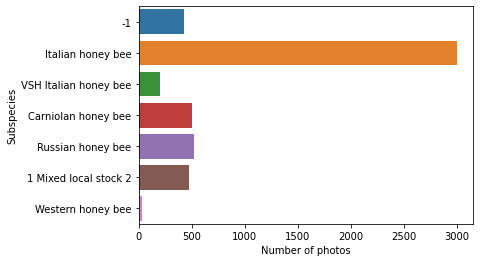

In [49]:
sns.countplot(y= 'subspecies', data= honey_bee_df )
plt.xlabel('Number of photos')
plt.ylabel('Subspecies')

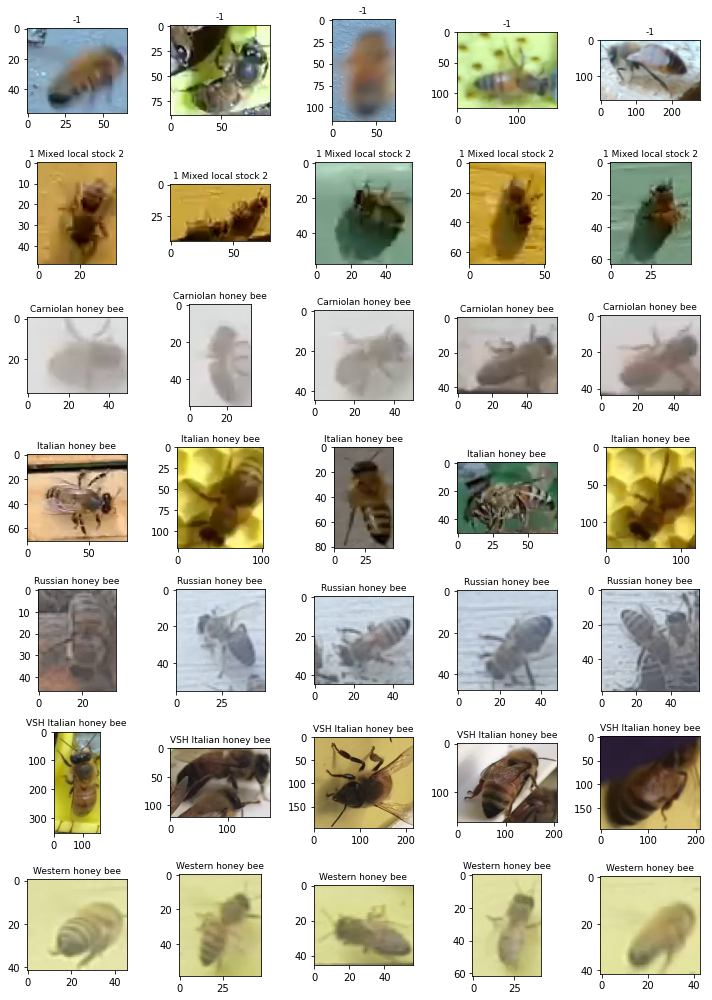

In [50]:
draw_category_images('subspecies')

In [51]:
tmp = honey_bee_df.groupby(['subspecies'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()

Text(32.99999999999999, 0.5, 'Subspecies')

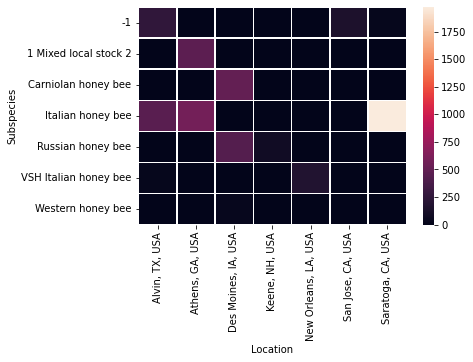

In [52]:
bee_pivot = pd.pivot_table(df, values="Images",index=["subspecies"], columns=["location"], fill_value=0)
ax = sns.heatmap(bee_pivot, linewidths=.5)
plt.xlabel('Location')
plt.ylabel('Subspecies')

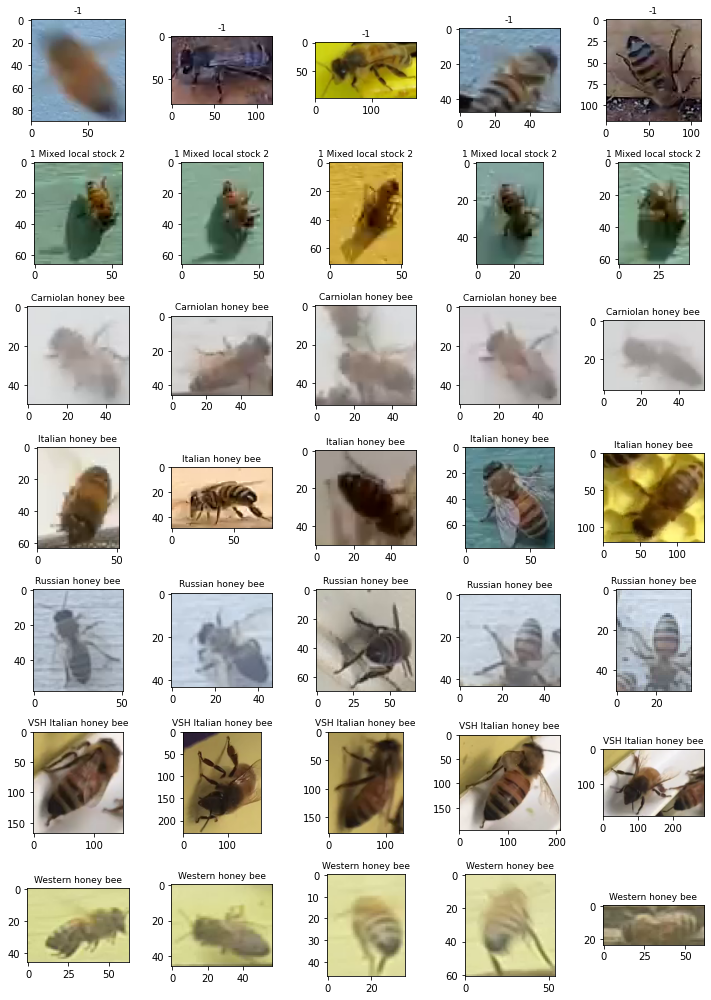

In [53]:
draw_category_images("subspecies")

In [54]:
tmp = honey_bee_df.groupby(['health'])['year'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

,health,year,Images
0,"Varroa, Small Hive Beetles",2018,472
1,ant problems,2018,457
2,"few varrao, hive beetles",2018,579
3,healthy,2018,3384
4,hive being robbed,2018,251
5,missing queen,2018,29


Text(0, 0.5, 'Health')

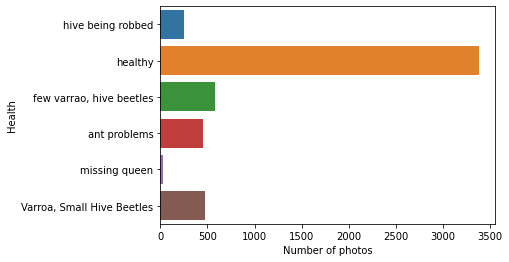

In [55]:
sns.countplot(y= 'health', data= honey_bee_df )
plt.xlabel('Number of photos')
plt.ylabel('Health')

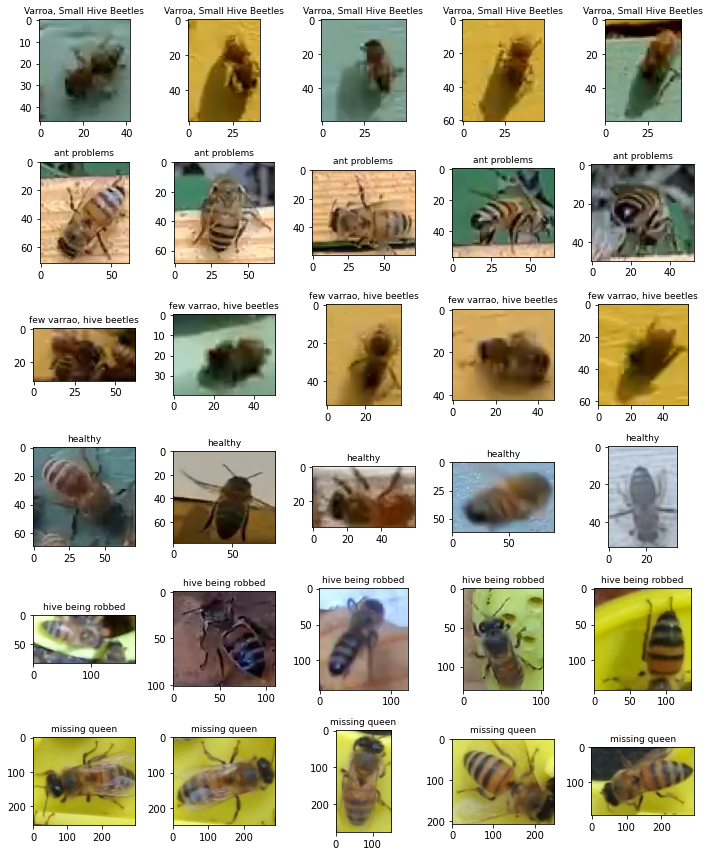

In [56]:
draw_category_images("health")

In [57]:
tmp = honey_bee_df.groupby(['pollen_carrying'])['subspecies'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()


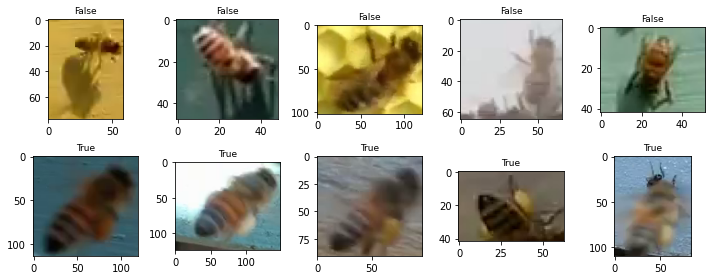

In [58]:
draw_category_images("pollen_carrying")

In [59]:
import skimage
import skimage.io
import skimage.transform
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
#from keras.utils import to_categorical
import tensorflow
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50
PATIENCE = 5
VERBOSE = 1

In [60]:
train_df, test_df = train_test_split(honey_bee_df, test_size=0.2, random_state=42, stratify=honey_bee_df['subspecies'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['subspecies'])

In [61]:
def read_image(file_name):
    image = skimage.io.imread(PATH + file_name)
    image = skimage.transform.resize(image, (100, 100), mode='reflect')
    return image[:,:,:3]

In [62]:
def categories_encoder(dataset, var='subspecies'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [63]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

In [64]:
model1=Sequential()
model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(100, 100,3), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [65]:
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True)
image_generator.fit(X_train)

In [66]:
train_model1  = model1.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_1,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


103/103 [==============================] - 29s 273ms/step - loss: 0.9684 - accuracy: 0.6715 - val_loss: 0.6942 - val_accuracy: 0.7657
Epoch 2/5
103/103 [==============================] - 29s 281ms/step - loss: 0.5583 - accuracy: 0.7857 - val_loss: 0.5100 - val_accuracy: 0.7899
Epoch 3/5
103/103 [==============================] - 28s 273ms/step - loss: 0.4350 - accuracy: 0.8244 - val_loss: 0.3742 - val_accuracy: 0.8478
Epoch 4/5
103/103 [==============================] - 28s 273ms/step - loss: 0.4240 - accuracy: 0.8323 - val_loss: 0.3494 - val_accuracy: 0.8647
Epoch 5/5
103/103 [==============================] - 30s 286ms/step - loss: 0.3847 - accuracy: 0.8480 - val_loss: 0.3130 - val_accuracy: 0.8551


In [67]:
score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3245011270046234
Test accuracy: 0.852173924446106


In [68]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [69]:
test_accuracy_report(model1)

                       precision    recall  f1-score   support

                   -1       0.98      0.63      0.77        86
1 Mixed local stock 2       0.44      0.12      0.18        94
  Carniolan honey bee       0.94      0.96      0.95       100
    Italian honey bee       0.83      0.97      0.90       602
    Russian honey bee       0.94      0.96      0.95       106
VSH Italian honey bee       0.82      0.68      0.74        40
    Western honey bee       0.88      1.00      0.93         7

             accuracy                           0.85      1035
            macro avg       0.83      0.76      0.77      1035
         weighted avg       0.83      0.85      0.83      1035

Loss function: 0.3245011270046234, accuracy: 0.852173924446106
